<a href="https://colab.research.google.com/github/El4h/ORE/blob/master/llmworkshop_language_in_vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 Language vectors and predictions: static and contextualized models

_[Marianne de Heer Kloots](https://mdhk.net/), October 2025_

This notebook contains some exercises to familiarize yourself with vector representations of words and language models. We'll first have a look at relationships between words encoded in a static word embedding model ([word2vec](https://en.wikipedia.org/wiki/Word2vec)), and then we'll have a look at two simple contextualized language models ([BERT](https://jalammar.github.io/illustrated-bert/) & [GPT2](https://jalammar.github.io/illustrated-gpt2/)).

In [ ]:
# install the gensim library
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 70.4 MB/s eta 0:00:00


In [ ]:
# @title Library imports
from google.colab import drive
import pickle
import torch
import os
from torch.nn import functional as F
import math
import pandas as pd
import numpy as np
import transformers
import gensim.downloader
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA
from collections import defaultdict
import plotly.express as px
import altair as alt
from transformers import BertForMaskedLM, AutoModelForCausalLM, AutoTokenizer

Make sure you have added the [tutorial folder](https://drive.google.com/drive/folders/1eBA6WF-NuCJ_zzi_9rUJzPGtUwL9MHmF?usp=sharing) as a shortcut to your Drive, and that the `TUTORIAL_PATH` variable in the cell below points to the location of the shortcut in your Drive. Then mount your Google Drive into this Colab notebook by running the cell.

In [ ]:
if not os.path.exists('drive'):
  drive.mount(f'/content/drive/')
TUTORIAL_PATH = 'drive/MyDrive/GiessenTutorial'

Mounted at /content/drive/


In [ ]:
## this will download a 300-dimensional word2vec model and save it to session storage
## (takes a while!)
# model_name = 'word2vec-google-news-300'
# n_features = 300
# word2vec_model = gensim.downloader.load(model_name)
# word2vec_model.save('word2vec.model')

## load pre-saved model from drive folder
word2vec_model = KeyedVectors.load(f'{TUTORIAL_PATH}/word2vec.model', mmap='r')

The cell below prints the words with the most similar vectors to the vector for the word 'banana' in the word2vec model. This may give you some idea of how [semantle](https://semantle.com/) works under the hood!

In [ ]:
word2vec_model.most_similar('banana')

[('bananas', 0.7523775696754456),
 ('pineapple', 0.6587537527084351),
 ('mango', 0.6365211009979248),
 ('pineapples', 0.6313878297805786),
 ('papaya', 0.6063665747642517),
 ('coconut', 0.6035483479499817),
 ('potato', 0.5747568607330322),
 ('melon', 0.5625775456428528),
 ('cashew', 0.562165379524231),
 ('tomato', 0.5590206384658813)]

We can also reproduce some of the classic [vector arithmetic analogies](https://kawine.github.io/blog/nlp/2019/06/21/word-analogies.html) with word2vec!

In [ ]:
def analogy(A, B, C):
    D = word2vec_model.most_similar(positive=[C, B], negative=[A])[0][0]
    return D

In [ ]:
analogy('small', 'smallest', 'big')

'biggest'

In [ ]:
analogy('good', 'fantastic', 'bad')

'horrible'

In [ ]:
analogy('man', 'woman', 'king')

'queen'

Below we visualize the spatial relations between words in a three-dimensional space, based on the first three principal components of the word2vec embeddings. Does this follow your expectations?

In [ ]:
words = ["boy", "girl", "man", "woman", "king", "queen", "prince", "princess"]

word2vec_word_vectors = np.stack([word2vec_model.get_vector(w) for w in words])
word2vec_word_PCs = pd.DataFrame(
    PCA(n_components=3).fit_transform(word2vec_word_vectors),
    columns=['PC1', 'PC2', 'PC3'], index=words
)
px.scatter_3d(word2vec_word_PCs, x='PC1', y='PC2', z='PC3', color=word2vec_word_PCs.index)

You can actually view a PCA of the entire word2vec embedding space [here](https://projector.tensorflow.org/). Can you find any interesting sub-clusters?

## Predicting words with language models
It's time to load some language models! We'll experiment with two classic architectures: BERT for _masked language modelling_ and GPT2 for _autoregressive language modelling_.
Recall the differences between the two:
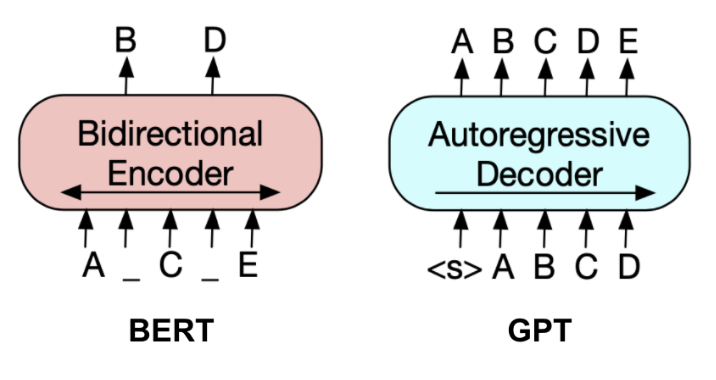

We'll load these models from the [HuggingFace hub](https://huggingface.co/), which is a very useful platform to find all sorts of models.

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = BertForMaskedLM.from_pretrained("google-bert/bert-base-uncased")
gpt_tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
gpt_model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# @title Helper functions for this section
def check_bert_predictions(context_before, prediction_target, context_after,
                           top_n=10, model=bert_model, tokenizer=bert_tokenizer):
  if not (type(model) == transformers.models.bert.modeling_bert.BertForMaskedLM):
    raise NotImplementedError

  inputs = tokenizer(f'{context_before} [MASK] {context_after}', return_tensors="pt")
  target_tokens = [tokenizer.decode(t) for t in tokenizer(prediction_target).input_ids[1:-1]]
  mask_token_idx = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]

  print(f'Checking BERT predictions for sentence: \n"{context_before} ____ {context_after}"\n')
  target_desc = f"multiple tokens! {target_tokens}" if len(target_tokens) > 1 else f"model target token: {target_tokens[0]}"
  print(f'Prediction target: {prediction_target} ({target_desc})')

  model.eval()
  with torch.no_grad():
    outputs = model(**inputs)

  # logits at the masked token
  masked_token_logits = outputs.logits[0, mask_token_idx, :]
  # taking the softmax gives us the probability
  masked_token_probs = F.softmax(masked_token_logits, dim=-1).detach().numpy().flatten()
  # top N most likely token ids
  masked_token_ids = np.argsort(masked_token_probs).flatten().tolist()[-top_n:]
  # tokens corresponding to these ids
  masked_tokens = [tokenizer.decode(mti) for mti in masked_token_ids]
  # probabilities corresponding to these tokens
  masked_token_probs = masked_token_probs[masked_token_ids].tolist()
  # sort the tokens and their probabilities in descending order
  desc_token_probs = list(zip(masked_tokens, masked_token_probs))[::-1]

  print(f'\nTop {top_n} masked-token predictions:')
  for token, prob in desc_token_probs:
    print('{0:<20}'.format(token), f"({'%.5f' % prob})")

  top_prediction = desc_token_probs[0]
  return top_prediction

def check_gpt_predictions(context_before, prediction_target, context_after,
                           top_n=10, model=gpt_model, tokenizer=gpt_tokenizer):
  if not (type(model) == transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel):
    raise NotImplementedError

  inputs = tokenizer(f'{context_before} {prediction_target} {context_after}', return_tensors="pt")
  target_tokens = [tokenizer.decode(t) for t in tokenizer(prediction_target).input_ids]
  target_start_idx = len(gpt_tokenizer(context_before).input_ids)

  print(f'Checking GPT predictions for sentence: \n"{context_before} ____ {context_after}"\n')
  target_desc = f"multiple tokens! {target_tokens}" if len(target_tokens) > 1 else f"model target token: {target_tokens[0]}"
  print(f'Prediction target: {prediction_target} ({target_desc})')

  model.eval()
  with torch.no_grad():
    outputs = model(**inputs)

  # logits at the token preceding the prediction target
  next_token_logits = outputs.logits[:, target_start_idx - 1, :]
  # taking the softmax gives us the probability
  next_token_probs = F.softmax(next_token_logits, dim=-1).detach().numpy()
  # top N most likely token ids
  next_token_ids = np.argsort(next_token_probs)[0][-top_n:]
  # tokens corresponding to these ids
  next_tokens = [gpt_tokenizer.decode(t).strip() for t in next_token_ids]
  # probabilities corresponding to these tokens
  next_token_probs = list(next_token_probs[:, next_token_ids][0])
  # sort the tokens and their probabilities in descending order
  desc_token_probs = list(zip(next_tokens, next_token_probs))[::-1]

  print(f'\nTop {top_n} next-token predictions after {tokenizer.decode(inputs.input_ids.flatten()[target_start_idx -1]).strip()}:')
  for token, prob in desc_token_probs:
    print('{0:<20}'.format(token), f"({'%.5f' % prob})")

  top_prediction = desc_token_probs[0]
  return top_prediction

def get_word_vectors(model, tokenizer, texts):
  """
  Return vector embeddings for each text in texts, for each layer of the model.
  """
  text_words = []
  text_vecs = defaultdict(list)
  model.eval()

  for text in texts:
    encoded = tokenizer(text, return_tensors="pt")
    input_ids = encoded['input_ids']
    attention_mask = encoded['attention_mask']

    with torch.no_grad():
      output = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

    states = output.hidden_states
    token_len = attention_mask.sum().item()
    decoded = tokenizer.convert_ids_to_tokens(input_ids[0], skip_special_tokens=False)

    if type(model) == transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel:
      word_indices = np.array(list(map(lambda e: -1 if e is None else e, encoded.word_ids())))[:token_len]
      word_groups = np.split(np.arange(word_indices.shape[0]), np.unique(word_indices, return_index=True)[1])[1:]
      text_words.append(["".join(list(map(lambda t: t[1:] if t[:1] == "Ġ" else t, np.array(decoded)[g]))) for g in word_groups])
      emb_layer = model.transformer.wte
    elif type(model) == transformers.models.bert.modeling_bert.BertForMaskedLM:
      word_indices = np.array(list(map(lambda e: -1 if e is None else e, encoded.word_ids())))[1:token_len - 1]
      word_groups = np.split(np.arange(word_indices.shape[0]) + 1, np.unique(word_indices, return_index=True)[1])[1:]
      text_words.append(["".join(list(map(lambda t: t[2:] if t[:2] == "##" else t, np.array(decoded)[g]))) for g in word_groups])
      emb_layer = model.bert.embeddings.word_embeddings
    else:
      raise NotImplementedError

    num_layers = model.config.num_hidden_layers
    for layer in range(0,num_layers+1):
      text_tokens_output = torch.stack([
          torch.stack([
              # model layer embedding
              states[layer].detach()[:, token_ids_word].mean(axis=1)
              if layer > 0 else
              # input embedding
              emb_layer(input_ids)[:, token_ids_word].mean(axis=1)
              ]).sum(axis=0).squeeze()
              for token_ids_word in word_groups
      ])
      text_vecs[layer].append(text_tokens_output.detach().numpy())

  for layer in range(0,num_layers+1):
    text_vecs[layer] = np.vstack(text_vecs[layer])

  return text_vecs

Let's first look at the input token embeddings that go into the first layer of the BERT model. They look pretty similar to the word2vec version above!

In [ ]:
words = ["boy", "girl", "man", "woman", "king", "queen", "prince", "princess"]
bert_word_vectors = get_word_vectors(bert_model, bert_tokenizer, words)

In [ ]:
layer = 0
bert_word_PCs = pd.DataFrame(
    PCA(n_components=3).fit_transform(bert_word_vectors[layer]),
    columns=['PC1', 'PC2', 'PC3'], index=words
)
px.scatter_3d(bert_word_PCs, x='PC1', y='PC2', z='PC3', color=bert_word_PCs.index)

> **Exercise:** How does this develop over model layers?

Representing single words in isolation is not the main strength of contextualized models like BERT and GPT2, though. Let's have a look at their predictions of words in context.

> **Exercise:** What happens to BERT's predictions if you change something in `context_after` (e.g. flew -> swam)? What happens when you change something in `context_before` (e.g. cat -> shark)? What about GPT2?

In [ ]:
top_token, top_token_prob = check_bert_predictions(
    context_before='The hungry cat chased the small',
    prediction_target='bird',
    context_after='but it flew away.',
)

Checking BERT predictions for sentence: 
"The hungry cat chased the small ____ but it flew away."

Prediction target: bird (model target token: bird)

Top 10 masked-token predictions:
bird                 (0.16890)
creature             (0.11161)
animal               (0.10456)
dog                  (0.08357)
one                  (0.03242)
mouse                (0.03128)
cat                  (0.02571)
girl                 (0.02518)
boy                  (0.02157)
beast                (0.01971)


In [ ]:
top_token, top_token_prob = check_gpt_predictions(
    context_before='The hungry cat chased the small',
    prediction_target='bird',
    context_after='but it flew away.'
)

Checking GPT predictions for sentence: 
"The hungry cat chased the small ____ but it flew away."

Prediction target: bird (model target token: bird)

Top 10 next-token predictions after small:
cat                  (0.12301)
dog                  (0.06283)
,                    (0.05306)
boy                  (0.02707)
animal               (0.02630)
black                (0.02186)
man                  (0.02178)
girl                 (0.01916)
-                    (0.01683)
child                (0.01369)


Model-derived token probabilities are sometimes used to quantify predictability effects in language comprehension. Predictability effects can for example be measured in [ERP amplitudes in EEG experiments](https://doi.org/10.1162/nol_a_00105
 ) and in [reading times in eye-tracking or self-paced reading experiments](https://aclanthology.org/2025.acl-long.1214/).

Instead of raw probabilities, such studies usually operationalize predictability by _surprisal_. The surprisal value for a token is simply its negative log probability, i.e. surprisal will be higher for lower-probability tokens.

Here's a closer look into getting token probabilities and surprisal values from a GPT model:

In [ ]:
preceding_context = 'They returned the book to the'
target_word = 'library'

def gpt_word_prob(target_word, preceding_context=preceding_context, print_steps=False):
  # if the word is tokenized into multiple tokens, we'll take the first
  target_token_id = gpt_tokenizer.encode(' ' + target_word)[0]

  ctx_inputs = gpt_tokenizer(preceding_context, return_tensors="pt")
  with torch.no_grad():
    output = gpt_model(**ctx_inputs)
  # logits of the last hidden state
  next_token_logits = output.logits[:, -1, :]
  # taking the softmax gives us the probability
  next_token_probs = F.softmax(next_token_logits, dim=-1)
  # find the probability for the target token
  target_token_prob = next_token_probs[:, target_token_id].numpy().item()

  if print_steps:
    print('target token:', target_token_id, gpt_tokenizer.decode(target_token_id))
    print('output logits shape:', output.logits.shape)
    print('next token probs shape:', next_token_probs.shape)
    print(f'prob for target token:', target_token_prob)

  return target_token_prob

token_prob = gpt_word_prob('library', print_steps=True)

target token: 5888  library
output logits shape: torch.Size([1, 6, 50257])
next token probs shape: torch.Size([1, 50257])
prob for target token: 0.028046365827322006


In [ ]:
def surprisal(prob):
  return -math.log(prob)

preceding_context = 'They returned the book to the'
print(surprisal(gpt_word_prob('library')))
print(surprisal(gpt_word_prob('sandwich')))

3.573896215930401
12.516217995704771


## Lenses into model-internal predictions

It seems both BERT and GPT can come up with some reasonable predictions in the context of a sentence. But how do these predictions take shape within the model?

As a first look into model internals, we can see what happens when we feed earlier model layers into the model's output head (the output head is the operation that transforms hidden states into token predictions; it is called `lm_head` in our `gpt_model` and `cls` in our `bert_model`).

The idea of using the model's output head as a _lens_ into model internals was first introduced as the [logit lens](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens) for generative language models, but the same idea can be applied to many other kinds of models; see for example the [DecoderLens](https://aclanthology.org/2024.findings-naacl.296/) for Whisper and the [CTC-lens](https://doi.org/10.21437/Interspeech.2024-2490) for Wav2Vec2 models.

Below, we'll see how model predictions develop over each model's hidden layers for two different sentences, one prompting a verb and another one prompting an adjective.

> **Exercise:** Experiment by feeding the model a few different sentences and see if you can discover any patterns in the layerwise evolution of token predictions!

> **Note:** the `layerwise_bert_predictions` function will by default append `[MASK].` to the end of the input text. But you can also place your own `[MASK]` in your input; for example,
> ```
> print_layerwise_predictions(layerwise_bert_predictions("I'm trying out a [MASK] thing"))
> ```
> should give you BERT's predictions at the position of `[MASK]`.

In [ ]:
# @title Helper functions for this section
def layerwise_gpt_predictions(input_text, top_n=10, model=gpt_model, tokenizer=gpt_tokenizer):
  if not (type(model) == transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel):
    raise NotImplementedError
  # tokenize input text & get model outputs
  inputs = tokenizer(input_text, return_tensors="pt")

  model.eval()
  with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

  # compute layerwise predictions
  N_layers = len(outputs.hidden_states)
  logits_per_layer = {l: model.lm_head(outputs.hidden_states[l]) for l in range(N_layers)}
  probs_per_layer = {l: torch.softmax(logits_per_layer[l], dim=-1) for l in range(N_layers)}
  topn_tokids_per_layer = {l: torch.topk(probs_per_layer[l][:, -1, :], k=top_n, dim=-1).indices for l in range(N_layers)}
  topn_toks_per_layer = {l: [tokenizer.decode([tid]) for tid in topn_tokids_per_layer[l].flatten()] for l in range(N_layers)}

  # store token prediction properties to df
  token_annotations = []
  for layer, tok_ids in topn_tokids_per_layer.items():
    for n, tok_id in enumerate(tok_ids.flatten()):
      token = topn_toks_per_layer[layer][n].strip()
      token_prob = probs_per_layer[layer][:, -1, :].flatten()[tok_id].item()
      token_annotations.append((input_text, 'GPT', layer, n, token, tok_id.item(), token_prob))
  token_annotation_df = pd.DataFrame(token_annotations, columns=['input_text', 'model', 'layer', 'prediction_rank', 'token', 'token_id', 'token_prob'])
  return token_annotation_df

def layerwise_bert_predictions(input_text, top_n=10, model=bert_model, tokenizer=bert_tokenizer):
  if not (type(model) == transformers.models.bert.modeling_bert.BertForMaskedLM):
    raise NotImplementedError
  if not '[MASK]' in input_text:
    input_text = input_text.strip() + ' [MASK].'

  # tokenize input text & get model outputs
  inputs = tokenizer(input_text, return_tensors="pt")
  mask_token_idx = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]

  model.eval()
  with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

  # compute layerwise predictions
  N_layers = len(outputs.hidden_states)
  logits_per_layer = {l: model.cls(outputs.hidden_states[l]) for l in range(N_layers)}
  probs_per_layer = {l: torch.softmax(logits_per_layer[l], dim=-1) for l in range(N_layers)}
  topn_tokids_per_layer = {l: torch.topk(probs_per_layer[l][:, mask_token_idx, :], k=top_n, dim=-1).indices for l in range(N_layers)}
  topn_toks_per_layer = {l: [tokenizer.decode([tid]) for tid in topn_tokids_per_layer[l].flatten()] for l in range(N_layers)}

  # store token prediction properties to df
  token_annotations = []
  for layer, tok_ids in topn_tokids_per_layer.items():
    for n, tok_id in enumerate(tok_ids.flatten()):
      token = topn_toks_per_layer[layer][n].strip()
      token_prob = probs_per_layer[layer][:, mask_token_idx, :].flatten()[tok_id].item()
      token_annotations.append((input_text, 'BERT', layer, n, token, tok_id.item(), token_prob))
  token_annotation_df = pd.DataFrame(token_annotations, columns=['input_text', 'model', 'layer', 'prediction_rank', 'token', 'token_id', 'token_prob'])
  return token_annotation_df

def print_layerwise_predictions(token_pred_df):
  model = token_pred_df['model'].unique().item()
  input_text = token_pred_df['input_text'].unique().item()
  print(f'{model} predictions for input: "{input_text}"')
  print('LAYER\tTOKENS')
  for layer in token_pred_df['layer'].unique():
    predicted_tokens = token_pred_df[token_pred_df['layer'] == layer]['token'].tolist()
    print(layer, '\t', ' | '.join(predicted_tokens))
  print('\n')

def plot_probfrac_tokens(tokpred_df, n=10, width=800, height=500):
  # add text annotation coords
  tokpred_df = tokpred_df.sort_values(by=['layer', 'prediction_rank'], ascending=[True, False])
  tokpred_df['token_prob_norm'] = tokpred_df.groupby('layer')['token_prob'].transform(lambda x: x / x.sum())
  tokpred_df['x_start'] = tokpred_df.groupby('layer')['token_prob_norm'].cumsum() - tokpred_df['token_prob_norm']
  tokpred_df['x_mid'] = tokpred_df['x_start'] + tokpred_df['token_prob_norm'] / 2

  chart = alt.Chart(tokpred_df).mark_bar(size=20).encode(
    x=alt.X('token_prob', stack='normalize'),
    y=alt.Y('layer:N'),
    color=alt.Color('prediction_rank', scale=alt.Scale(scheme='bluepurple', reverse=True)),
    tooltip=['token']
  )

  text = alt.Chart(tokpred_df).mark_text(color='white').encode(
      x=alt.X('x_mid:Q', scale=alt.Scale(reverse=True), axis=None),
      y=alt.Y('layer:N'),
      text=alt.Text('token')
  )

  input_text = tokpred_df['input_text'].unique().item()

  return (chart + text).resolve_scale(x='independent').properties(width=width, height=height, title=f'Layerwise top {n} token predictions for "{input_text}"')

In [ ]:
verb_sentence = 'At the workshop we really'
adj_sentence = 'The workshop is really'

bert_adj_predictions = layerwise_bert_predictions(adj_sentence)
bert_verb_predictions = layerwise_bert_predictions(verb_sentence)

gpt_adj_predictions = layerwise_gpt_predictions(adj_sentence)
gpt_verb_predictions = layerwise_gpt_predictions(verb_sentence)

In [ ]:
print_layerwise_predictions(bert_adj_predictions)
print_layerwise_predictions(bert_verb_predictions)
plot_probfrac_tokens(bert_adj_predictions)

BERT predictions for input: "The workshop is very [MASK]."
LAYER	TOKENS
0 	 back | lot | . | and | defense | mad | pride | color | sis | left
1 	 set | part | life | vulnerable | hard | fall | cent | point | angle | risk
2 	 set | part | vulnerable | present | point | bala | visible | reflective | late | barrier
3 	 set | popular | well | stable | present | hon | secure | clear | serious | cool
4 	 late | close | popular | well | successful | secure | alive | stable | present | fast
5 	 late | close | popular | fast | alive | active | dry | successful | well | present
6 	 close | late | well | fast | popular | divided | mobile | transparent | flexible | different
7 	 close | late | small | busy | different | well | active | popular | focused | developed
8 	 close | small | active | large | important | expensive | late | popular | well | fast
9 	 active | small | close | popular | large | open | successful | conservative | late | expensive
10 	 small | active | close | large | open | bu

alt.LayerChart(...)

In [ ]:
print_layerwise_predictions(gpt_adj_predictions)
print_layerwise_predictions(gpt_verb_predictions)
plot_probfrac_tokens(gpt_adj_predictions)

GPT predictions for input: "The workshop is very"
LAYER	TOKENS
0 	 very | VERY | very | extremely | quite | Very | incredibly | extraordinarily | exceedingly | tremendously
1 	 the | a | very | well | , | much | high | low | good | different
2 	 rare | much | different | very | low | important | well | good | clear | high
3 	 rare | much | different | very | well | good | important | low | close | simple
4 	 much | very | good | different | well | important | rare | low | , | simple
5 	 much | very | , | different | well | good | important | a | the | close
6 	 , | much | different | a | good | the | very | - | well | important
7 	 , | much | the | a | good | - | very | well | different | in
8 	 , | much | the | - | a | good | in | very | and | .
9 	 , | - | much | the | a | . | in | well | " | good
10 	 , | the | much | - | a | . | " | well | and | in
11 	 , | the | - | . | a | " | and | in | to | of
12 	 important | much | interesting | open | well | informative | useful | similar | 

alt.LayerChart(...)